In [38]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from matplotlib import pyplot as plt
import requests
import pprint
from enum import Enum
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn import preprocessing


In [132]:
pp = pprint.PrettyPrinter(indent=2)

In [3]:

class Attributes(Enum):
    PACE = 'pace'
    SHOT = 'shot'
    PASS = 'pass'
    DRIBBLE = 'dribble'
    DEFENSE = 'defense'
    PHYSICAL = 'physical'
    
class Positions(Enum):
    ATTACKER = 0
    LEFT_WING = 1
    RIGHT_WING = 2
    CENTER_MID = 3
    DEFENSIVE_MID = 4
    CENTER_BACK = 5
    FULL_BACK = 6
    KEEPER = 7

n_pages = 180

In [4]:
data = []
for i in range(1, n_pages):
    response = requests.get('https://www.easports.com/fifa/ultimate-team/api/fut/item?page={}'.format(i))
    json = response.json()
    data.append(json)

items = [item['items'] for item in data]
items = [item for sublist in items for item in sublist]

In [5]:
players = []
for item in items:
    player = dict()
    if not item['commonName']:
        player.update({'name': item['firstName'] + ' ' + item['lastName']})
    else:
        player.update({'name': item['commonName']})

    all_attributes = []
    for attribute in item['attributes']:
        attributes = dict()
        attribute_name = attribute['name']
        attribute_value = attribute['value']
        attributes['value'] = attribute_value
        if attribute_name == 'fut.attribute.PAC':
            attributes['name'] = Attributes.PACE.name
        elif attribute_name == 'fut.attribute.SHO':
            attributes['name'] = Attributes.SHOT.name
        elif attribute_name == 'fut.attribute.PAS':
            attributes['name'] = Attributes.PASS.name
        elif attribute_name == 'fut.attribute.DRI':
            attributes['name'] = Attributes.DRIBBLE.name
        elif attribute_name == 'fut.attribute.DEF':
            attributes['name'] = Attributes.DEFENSE.name
        elif attribute_name == 'fut.attribute.PHY':
            attributes['name'] = Attributes.PHYSICAL.name
        all_attributes.append(attributes)
    
    player['attributes'] = all_attributes
    player['rating'] = item['rating']
    if item['position'] == 'ST' or item['position'] == 'CF':
        player['position'] = Positions.ATTACKER.value
    elif item['position'] == 'LW' or item['position'] == 'LM' or item['position'] == 'LF':
        player['position'] = Positions.LEFT_WING.value
    elif item['position'] == 'RW' or item['position'] == 'RM' or item['position'] == 'RF':
        player['position'] = Positions.RIGHT_WING.value
    elif item['position'] == 'CM' or item['position'] == 'CAM':
        player['position'] = Positions.CENTER_MID.value
    elif item['position'] == 'CDM':
        player['position'] = Positions.DEFENSIVE_MID.value
    elif item['position'] == 'CB':
        player['position'] = Positions.CENTER_BACK.value
    elif item['position'] == 'LB' or item['position'] == 'RB' or item['position'] == 'LWB' or item['position'] == 'RWB':
        player['position'] = Positions.FULL_BACK.value
    elif item['position'] == 'GK':
        player['position'] = Positions.KEEPER.value
    player['position'] = keras.utils.to_categorical(player['position'], num_classes=8)
    players.append(player)
            

    

In [114]:
player_data = []
labels = []
for i in range(len(players)-100):
    data = []
    for attribute in players[i]['attributes']:
        data.append(attribute['value'])
    inputs = (data, players[i].get('position'), players[i]['name'])
    player_data.append(inputs)
    labels.append(players[i]['rating'])
        
labels = np.asarray(labels)
training_x, testing_x, training_y, testing_y = train_test_split(player_data, labels, test_size=0.25, random_state=42)


([97, 99, 95, 98, 50, 95], array([1., 0., 0., 0., 0., 0., 0., 0.], dtype=float32), 'Cristiano Ronaldo')


In [115]:
training_input_attributes = [d[0] for d in training_x]
training_input_position = [d[1] for d in training_x]
training_names = [d[2] for d in training_x]
testing_input_attributes = [d[0] for d in testing_x]
testing_input_position = [d[1] for d in testing_x]
testing_names = [d[2] for d in testing_x]

In [49]:
def plot_loss(loss):
    epochs = [i for i, _ in enumerate(loss)]
    plt.yscale('log')
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.plot(epochs, loss)
    plt.show()

In [68]:
input_position = keras.layers.Input(shape=(8,))
dense_position = keras.layers.Dense(units=24, activation='relu')(input_position)
# dense_position = keras.layers.Dense(units=8, activation='relu')(dense_position)

input_attributes = keras.layers.Input(shape=(6,))
dense_attributes = keras.layers.Dense(units=24, activation='relu')(input_attributes)
# dense_attributes = keras.layers.Dense(units=8, activation='relu')(dense_attributes)

concat_player = keras.layers.concatenate([dense_position, dense_attributes])
prediction = keras.layers.Dense(units=1)(concat_player)
model = keras.models.Model(inputs=[input_position, input_attributes], outputs=prediction)

model.compile(loss='mean_squared_error', optimizer=optimizers.Adam(lr=0.001))
history = model.fit([training_input_position, training_input_attributes], training_y, epochs=60, batch_size=4)


Epoch 1/60
3147/3147 [==============================] - 3s 945us/step - loss: 91.5660
Epoch 2/60
3147/3147 [==============================] - 2s 542us/step - loss: 15.6609
Epoch 3/60
3147/3147 [==============================] - 2s 495us/step - loss: 12.3137
Epoch 4/60
3147/3147 [==============================] - 1s 390us/step - loss: 10.9058
Epoch 5/60
3147/3147 [==============================] - 1s 386us/step - loss: 10.4265
Epoch 6/60
3147/3147 [==============================] - 1s 348us/step - loss: 9.6799
Epoch 7/60
3147/3147 [==============================] - 1s 436us/step - loss: 9.8478
Epoch 8/60
3147/3147 [==============================] - 2s 513us/step - loss: 9.0108
Epoch 9/60
3147/3147 [==============================] - 1s 373us/step - loss: 8.7121
Epoch 10/60
3147/3147 [==============================] - 1s 437us/step - loss: 8.7620
Epoch 11/60
3147/3147 [==============================] - 1s 452us/step - loss: 8.3740
Epoch 12/60
3147/3147 [==============================] - 1

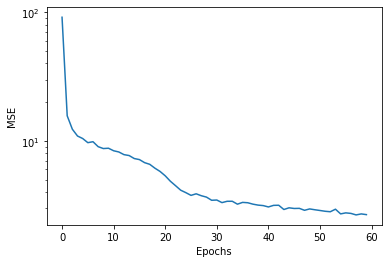

In [69]:
plot_loss(history.history['loss'])

In [122]:
def predict(model, index):
    attributes, position, name = testing_x[index]
    rating = model.predict([np.expand_dims(position, axis=0), np.expand_dims(np.array(attributes), axis=0)])
    position = np.where(position==1)[0]
    if position == 0:
        position = 'ATTACKER'
    elif position == 1:
        position = 'LEFT WING'
    elif position == 2:
        position = 'RIGHT WING'
    elif position == 3:
        position = 'CENTER MID'
    elif position == 4:
        position = 'CENTER DEFENSIVE MID'
    elif position == 5:
        position = 'CENTER BACK'
    elif position == 6:
        position = 'FULL BACK'
    elif position == 7:
        position = 'KEEPER'
    
    prediction = {
        'name': name,
        'attributes': attributes,
        'position': position,
        'rating': round(rating[0][0]),
        'actual label': testing_y[index]
    }
    return prediction
    

In [134]:
for i in range(25):
    pp.pprint(predict(model, i))

{ 'actual label': 95,
  'attributes': [76, 55, 75, 78, 96, 92],
  'name': 'Giorgio Chiellini',
  'position': 'CENTER BACK',
  'rating': 94.0}
{ 'actual label': 83,
  'attributes': [68, 73, 78, 87, 64, 68],
  'name': 'Naby Keïta',
  'position': 'CENTER MID',
  'rating': 82.0}
{ 'actual label': 90,
  'attributes': [88, 92, 80, 88, 60, 85],
  'name': 'Carlos Tévez',
  'position': 'ATTACKER',
  'rating': 90.0}
{ 'actual label': 81,
  'attributes': [61, 56, 74, 70, 80, 81],
  'name': 'Guido Rodríguez',
  'position': 'CENTER DEFENSIVE MID',
  'rating': 82.0}
{ 'actual label': 81,
  'attributes': [62, 70, 82, 77, 75, 78],
  'name': 'James Milner',
  'position': 'CENTER MID',
  'rating': 81.0}
{ 'actual label': 86,
  'attributes': [92, 80, 84, 90, 41, 60],
  'name': 'Alejandro Gómez',
  'position': 'ATTACKER',
  'rating': 87.0}
{ 'actual label': 94,
  'attributes': [93, 96, 87, 95, 55, 90],
  'name': 'Alexandre Lacazette',
  'position': 'ATTACKER',
  'rating': 94.0}
{ 'actual label': 83,
  'at